In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

# Dataset_Preparation and Sampling

In [3]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10
image_size = 224
hidden_nodes = 128

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)
dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)
print("Total images:", len(dataset))
print("Classes:", dataset.classes)

Using Colab cache for faster access to the 'flowers-recognition' dataset.
Total images: 4317
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [4]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [6]:
class CustomMobileNet(nn.Module):
    def __init__(self, num_classes=5, pretrained=True, freeze_backbone=True):
        super(CustomMobileNet, self).__init__()
        backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
        self.features = backbone.features
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False
        out_channels = backbone.last_channel
        self.pool = nn.AdaptiveMaxPool2d((1, 1))
        self.bn = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.bn(x)
        x = self.fc(x)
        return x

## Correct and optimised training loop

⚡ Critical Tip: "Catastrophic Forgetting"
When you unfreeze the base model, be very careful with your learning rate.

If you use a standard learning rate (e.g., 0.001) on the whole model, the random initialization of your new Dense layer will cause massive error gradients that propagate back and "destroy" the delicate, pre-trained patterns in the MobileNet base. This is called catastrophic forgetting.

Best Practice: Use Differential Learning Rates. Give the new Dense layer a higher learning rate, and the MobileNet base a much smaller one (usually 10x or 100x smaller).

````python
    optimizer = torch.optim.Adam([
    # The pre-trained base: very low learning rate to gently nudge weights
    {'params': model.features.parameters(), 'lr': 1e-4},
    
    # The new head: standard learning rate to learn quickly
    {'params': model.bn.parameters(), 'lr': 1e-3},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])
````


The below given code is almost generated by LLM but I understood the code clearly and in detail every single aspect adn added comments in it too

In [9]:
# 1. Setup Device (Critical for speed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Move model to device
model = CustomMobileNet().to(device)
criterion = nn.CrossEntropyLoss()

# Optimizer with filtering all the gradients which have reuire_grad = False which is the features of the mobileNetV2 Architecture
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.001
)

loss_values = []
training_accuracy = []
validation_accuracy = []

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        # Move data to GPU/CPU correct practice
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        running_loss += loss.item()
        
        # Calculate Training Accuracy ON THE FLY (No second loop needed!)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        # Vectorized comparison (Fast!)
        correct_train += (predicted == labels).sum().item()

    # Store epoch metrics
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode (Important for BatchNorm!)
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Training on: cuda
Epoch [1/10] | Loss: 0.5645 | Train Acc: 0.7950 | Val Acc: 0.8724
Epoch [2/10] | Loss: 0.3664 | Train Acc: 0.8738 | Val Acc: 0.8794
Epoch [3/10] | Loss: 0.3195 | Train Acc: 0.8882 | Val Acc: 0.8863
Epoch [4/10] | Loss: 0.3100 | Train Acc: 0.8888 | Val Acc: 0.8863
Epoch [5/10] | Loss: 0.3073 | Train Acc: 0.8862 | Val Acc: 0.8770
Epoch [6/10] | Loss: 0.2807 | Train Acc: 0.8929 | Val Acc: 0.8770
Epoch [7/10] | Loss: 0.2691 | Train Acc: 0.9004 | Val Acc: 0.8677
Epoch [8/10] | Loss: 0.2477 | Train Acc: 0.9088 | Val Acc: 0.8747
Epoch [9/10] | Loss: 0.2620 | Train Acc: 0.9068 | Val Acc: 0.8561
Epoch [10/10] | Loss: 0.2601 | Train Acc: 0.8984 | Val Acc: 0.8770


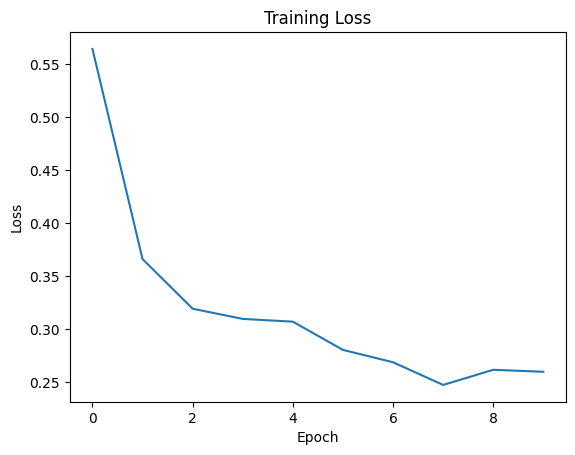

In [26]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

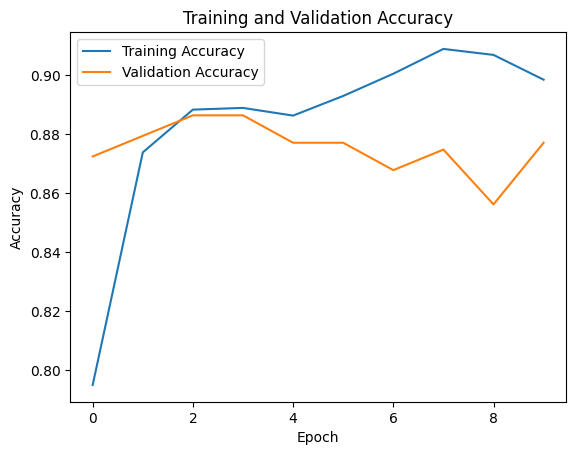

In [27]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [28]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")

Overall test Accuracy: 0.8981


We can clearly see a huge jump in accuracy around 0.89 from what we are getting(0.49) despite trying best from just deep neural networks.